# This is a test code for plotting the inter area connectivity results


In [1]:
import os
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
import sys
sys.path.insert(0, '/Users/elhamb/Documents/Codes/Git/MouseVisualCoding/MouseVisCode')
sys.path.insert(0,'/Users/elhamb/Documents/Codes/Git/MouseVisualCoding/Visualization/pydynet')
import lfp_session as LFPS
import pdc_functions as PDCF
from dynet_con import dynet_connplot
import _pickle as cPickle
import numpy as np
from itertools import compress
import tensorly.decomposition as tldecom
import matplotlib.pyplot as plt


## Load the previousley computed iPDC matrices

In order to load the iPDC matrices you either select the file with their names, or you provide the analysis parameter that was used before

In [2]:
ResultPath = '/Volumes/Elham-Unifr/Data/AllenBrainAll/Results/AverageResults'  # where to save the results

# parameters for preprocessing
cond_name = 'drifting_gratings'  # condition for iPDC analysis
down_sample_rate = 5  # down-sampling rate-> orginal data is 1250
pre_stim = 1  # prestimulus time window, in seconds
preproc_dict_BO = { # which preprocessing to use for PDC analysis
    'cond_name': cond_name,
    'srate': down_sample_rate,
    'prestim': pre_stim
}

# parameters for iPDC analsis
ROI_list = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']  # ROIs to include
Mord = 15  # Model order
ff = .98  # Filtering factor
pdc_method = 'iPDC'  # Method for connectivity estimation
# a list of dictionaries, each element of list indicate the parameters to consider on conditions for FC analysis,
# Note: put the values of dict as list of params
stim_params = [{'contrast': [.8], 'temporal_frequency':[2.0]}]

PDCparam_dict = {
    'ROI_list': ROI_list,
    'Mord': Mord,
    'ff': ff,
    'pdc_method': pdc_method,
    'stim_param': stim_params
}

In [3]:
filename = PDCF.search_PDC("AverageData_ROI", ResultPath, PDCparam_dict, preproc_dict_BO) # full data

#load the average file:
file = open(filename, "rb")
dataPickle = file.read()
file.close()
Arg_dict = cPickle.loads(dataPickle)
Arg_dict.keys()
Arg_dict['PDC_Average_BO'].keys()

dict_keys(['session_ids', 'ROIs', 'PDCs'])

Now we plot the average for each ROI and animal set

In [ ]:
# make a folder for a iPDC analysis with a specific set of parameters
figure_folder = filename.split('.pkl')[0]
if not os.path.isdir(figure_folder):
    os.mkdir(figure_folder)

# extract the name of animal sets
all_vars = list(Arg_dict.keys())
set_names = list(compress(all_vars,[x.find('PDC_Average')==0 for x in all_vars]))

#iterate over animal sets and save their ROI results
for sn in set_names:
    for roi in Arg_dict[sn]['ROIs']:
        ConnMatrix = Arg_dict[sn]['PDCs'][roi]
        figure_name = os.path.join(figure_folder,'{}_{}.png'.format(roi,sn))
        #plot_PDC_range(ConnMatrix, [-.3,1],figure_name)
        TRange = [-.3,1]
        T = ConnMatrix.time.values
        ConnMatrix2 = ConnMatrix.copy()
        ConnMatrix2 = ConnMatrix2.isel(time = np.where((T>=TRange[0]) & (T<=TRange[1]))[0])
        ConnMatrix2.time.values = ConnMatrix2.time.values/1000
        dynet_connplot(ConnMatrix2,ConnMatrix2.time.values,ConnMatrix2.freq.values,
                       labels=['L{}'.format(x) for x in range(1,7)],quantrange=[0.1, 0.8],
                       cmap = 'jet',SC = None,univ = 0,figure_name = figure_name)

## PARAFAC analysis to confirm if there is any similarity

In [16]:
figure_folder = filename.split('.pkl')[0]
animal_set = 'PDC_Average_all'
PARAFAC = {}
ttime = {}
ncomp = 3

for roi in Arg_dict[animal_set]['ROIs']:
    print(roi)
    temp = Arg_dict[animal_set]['PDCs'][roi]

    dims = temp.data.shape
    
    ttime[roi] = temp.time.values[100:550]

    temp2 = temp.data.reshape(dims[0]*dims[1],dims[2],dims[3])

    Ind = np.setdiff1d(np.array(range(0,36)),np.array(range(0,36,7)));#
    
    PARAFAC[roi] = tldecom.non_negative_parafac(temp2[Ind,:,100:550], rank=ncomp)
    
    
    #PARAFAC[roi] = tldecom.parafac(Temp2[Ind,:,100:550], rank=NComp)

VISp
VISrl
VISam
VISpm
VISal
VISl


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


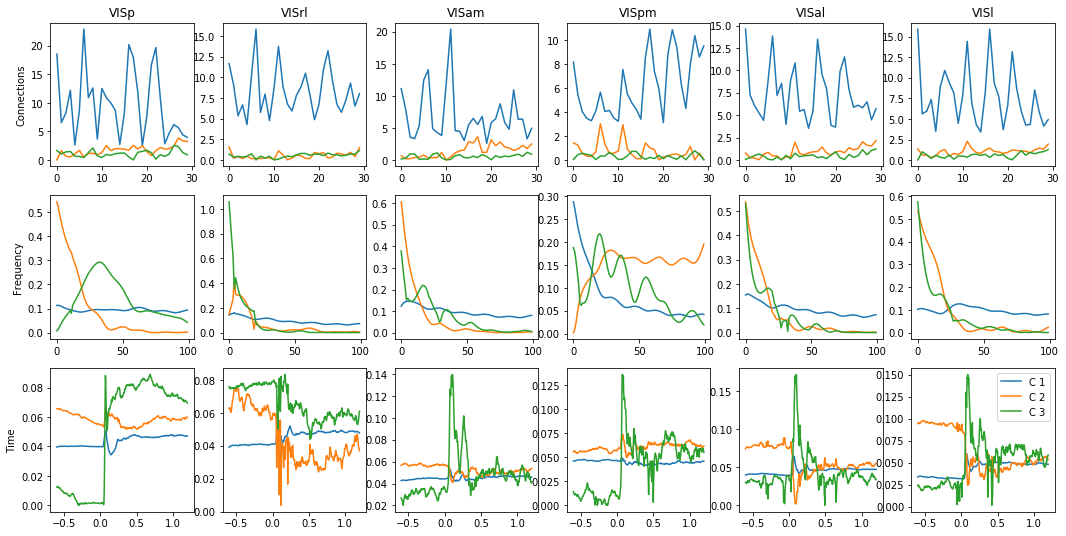

In [17]:
nroi =  len(Arg_dict[animal_set]['ROIs'])
dims = len(PARAFAC['VISp'].factors)
modes_names = ['Connections','Frequency','Time']
labels_comp = ['C {}'.format(x) for x in range(1,ncomp+1)]
fig, axs = plt.subplots(nrows = 3, ncols = nroi, figsize = (6*3,1.5*nroi))

for roi in range(0,nroi):
    roi_name = Arg_dict[animal_set]['ROIs'][roi]
    for dim in range(0,dims):
        #conn = np.zeros(dims[0],dims[1],NComp)
        if dim==2:
            axs[dim,roi].plot(ttime[roi_name],PARAFAC[roi_name].factors[dim][:,:],label='None')
        else:
            axs[dim,roi].plot(PARAFAC[roi_name].factors[dim][:,:])
            
        if dim==0:
            axs[dim,roi].set_title(roi_name)
            
        if roi==0:
            axs[dim,roi].set_ylabel(modes_names[dim])
            
        if (roi==nroi-1) & (dim==dims-1):
            handles, labels = axs[dim,roi].get_legend_handles_labels()
            axs[dim,roi].legend(handles,labels_comp)

plt.savefig(os.path.join(figure_folder,'PARAFAC_NComp{}_{}.eps'.format(ncomp,animal_set)), bbox_inches='tight')

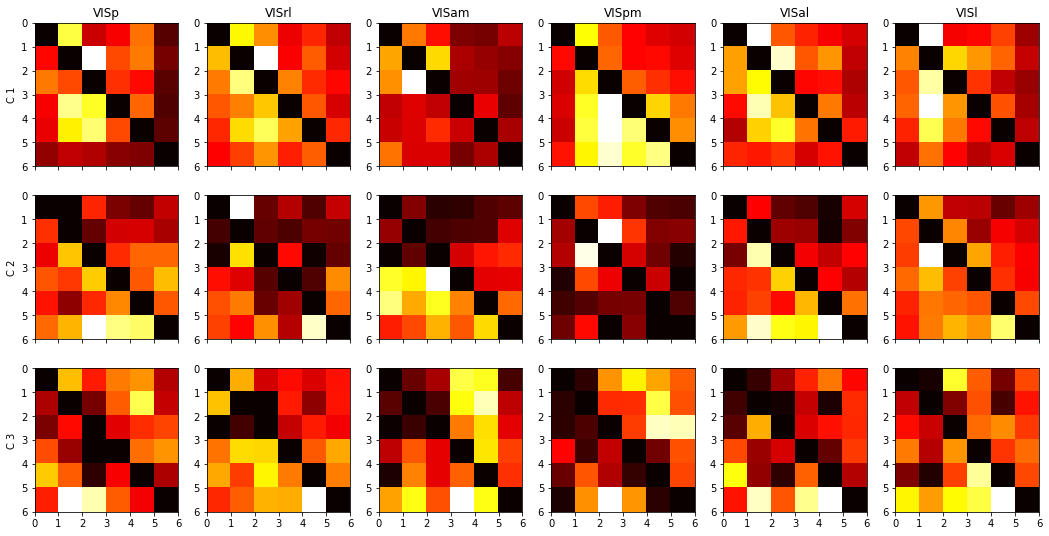

In [18]:
fig, axs = plt.subplots(nrows = ncomp, ncols = nroi, figsize = (6*ncomp,1.5*nroi),sharex=True)

for roi in range(0,nroi):
    roi_name = Arg_dict[animal_set]['ROIs'][roi]
    for c in range(0,ncomp):
        # Reshape the connectivity matrix
        Temp = np.zeros([6,6]).reshape(36)
        Temp[Ind] = PARAFAC[roi_name].factors[0][:,c]
        axs[c,roi].pcolormesh(Temp.reshape(6,6),cmap='hot')
        
        axs[c,roi].set_xticks(range(0,7))        
        if c==0:
            axs[c,roi].set_title(roi_name)
        if roi==0:
            axs[c,roi].set_ylabel('C {}'.format(c+1))
        axs[c,roi].invert_yaxis()
        
plt.savefig(os.path.join(figure_folder,'PARAFAC_NComp{}_{}_conn.eps'.format(ncomp,animal_set)), bbox_inches='tight')

Now lets put all the data together and redo PARAFAC (normalize the data first)

In [163]:
animal_set = 'PDC_Average_FC'
iPDC_norm={}
for roi in Arg_dict[animal_set]['ROIs']:
 
    temp = Arg_dict[animal_set]['PDCs'][roi]

    dims = temp.data.shape

    ttime[roi] = temp.time.values[100:550]

    temp2 = temp.data.reshape(dims[0]*dims[1],dims[2],dims[3])

    #normalize the ROI data

    Ind = np.setdiff1d(np.array(range(0,36)),np.array(range(0,36,7)));#
    temp_norm = temp2[Ind,:,100:550]
    NNorm = np.linalg.norm(temp_norm)
    iPDC_norm[roi] = temp_norm/NNorm
    #PARAFAC[roi] = tldecom.non_negative_parafac(temp_norm, rank=ncomp)



In [142]:
ncomp = 3
ROIs = ['VISp','VISl','VISrl','VISal','VISpm','VISam']
ROIs_short = ['V1','LM','RL','RL','PM','AM']
PARAFAC = tldecom.non_negative_parafac(np.stack([iPDC_norm[roi] for roi in ROIs],axis=3), rank=ncomp)

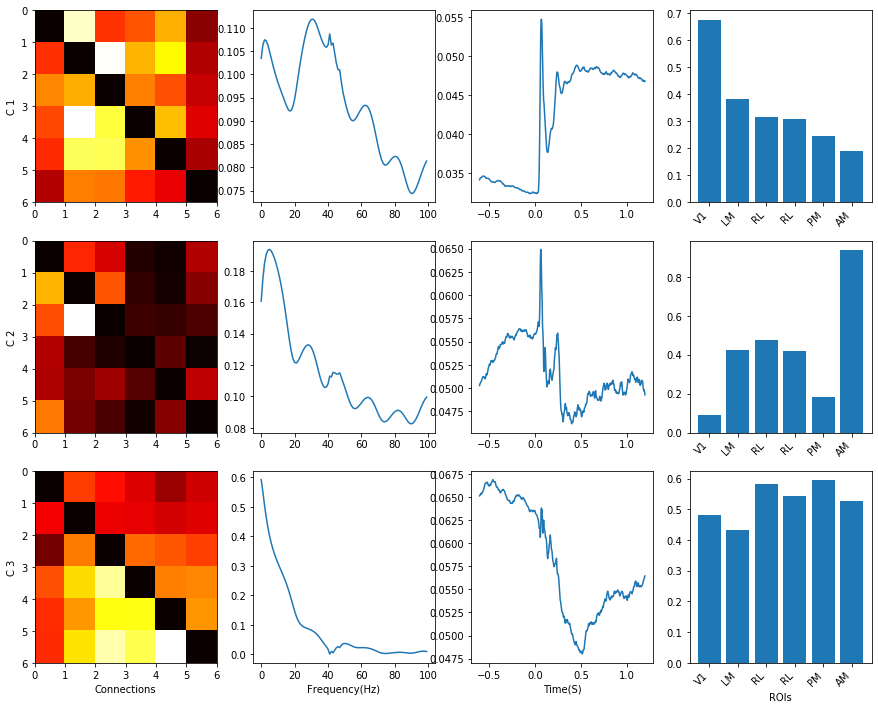

In [119]:
dims = len(PARAFAC.factors)
dims_labels = ['Connections','Frequency(Hz)','Time(S)','ROIs']
fig, axs = plt.subplots(nrows = ncomp, ncols = dims, figsize = (15,12))

for dim in range(0,dims):
    for c in range(0,ncomp):
        # Reshape the connectivity matrix
        if dim==0
            Temp = np.zeros([6,6]).reshape(36)
            Temp[Ind] = PARAFAC.factors[dim][:,c]
            axs[c,dim].pcolormesh(Temp.reshape(6,6),cmap='hot')
            axs[c,dim].set_xticks(range(0,7)) 
            axs[c,dim].invert_yaxis()


        elif dim==1:
            axs[c,dim].plot(PARAFAC.factors[dim][:,c])
        elif dim==2:
            axs[c,dim].plot(ttime['VISl'],PARAFAC.factors[dim][:,c])
        else:
            axs[c,dim].bar(ROIs,PARAFAC.factors[dim][:,c])
            axs[c,dim].set_xticklabels(ROIs_short, rotation = 45, ha="right")

        if dim==0:
            axs[c,dim].set_ylabel('C {}'.format(c+1))
        
        if c==ncomp-1:
            axs[c,dim].set_xlabel(dims_labels[dim])

plt.savefig(os.path.join(figure_folder,'PARAFAC_NComp{}_{}_roisall.eps'.format(ncomp,animal_set)), bbox_inches='tight')

Now let's try something different. Put ROIs and connections in one dimension

In [164]:
ncomp = 4
ROIs = ['VISp','VISl','VISrl','VISal','VISpm','VISam']
ROIs_short = ['V1','LM','RL','RL','PM','AM']
iPDC_norm_stk = np.moveaxis(np.stack([iPDC_norm[roi] for roi in ROIs],axis=3),-1,1)
dims = iPDC_norm_stk.shape
iPDC_norm_stk = iPDC_norm_stk.reshape(dims[0]*dims[1],dims[2],dims[3])
PARAFAC = tldecom.non_negative_parafac(iPDC_norm_stk, rank=ncomp)

fac0 = PARAFAC.factors[0].reshape(dims[0],dims[1],ncomp)

PARAFAC2 = [fac0.mean(axis=1),PARAFAC.factors[1],PARAFAC.factors[2], fac0.mean(axis=0)]

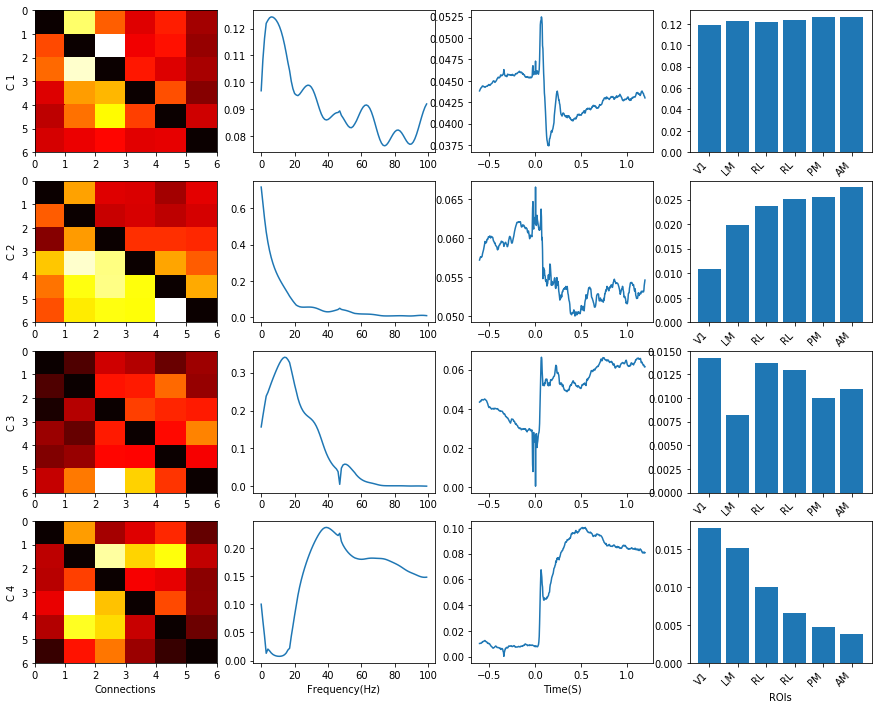

In [165]:
dims = len(PARAFAC2)
dims_labels = ['Connections','Frequency(Hz)','Time(S)','ROIs']
fig, axs = plt.subplots(nrows = ncomp, ncols = dims, figsize = (15,12))

for dim in range(0,dims):
    for c in range(0,ncomp):
        # Reshape the connectivity matrix
        if dim==0:
            Temp = np.zeros([6,6]).reshape(36)
            Temp[Ind] = PARAFAC2[dim][:,c]
            axs[c,dim].pcolormesh(Temp.reshape(6,6),cmap='hot')
            axs[c,dim].set_xticks(range(0,7)) 
            axs[c,dim].invert_yaxis()


        elif dim==1:
            axs[c,dim].plot(PARAFAC2[dim][:,c])
        elif dim==2:
            axs[c,dim].plot(ttime['VISl'],PARAFAC2[dim][:,c])
        else:
            axs[c,dim].bar(ROIs,PARAFAC2[dim][:,c])
            axs[c,dim].set_xticklabels(ROIs_short, rotation = 45, ha="right")

        if dim==0:
            axs[c,dim].set_ylabel('C {}'.format(c+1))
        
        if c==ncomp-1:
            axs[c,dim].set_xlabel(dims_labels[dim])

#plt.savefig(os.path.join(figure_folder,'PARAFAC_NComp{}_{}_roisall.eps'.format(ncomp,animal_set)), bbox_inches='tight')